# Importing Libraries


In [24]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,OrthogonalMatchingPursuit, OrthogonalMatchingPursuit,  Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras import layers
from tensorflow import keras
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')

In [25]:
%matplotlib inline

# Loading the data

In [26]:
file_path = "data/Sensor_Data.xlsx"

dfs = []

with pd.ExcelFile(file_path) as xlsx:
    for sheet_name in xlsx.sheet_names:
        df = pd.read_excel(xlsx, sheet_name)
        dfs.append(df)

combined_df = df = pd.concat(dfs, ignore_index=True)
df = combined_df.copy()
df["Irradiance(W/m2)"] = df["Light Intensity(lumens)"]*0.079

mod_df = pd.DataFrame(columns= ["Timestamp", "Temperature(Â°C)", "Irradiance(W/m2)", "Power(Watts)"])
count = 0
while count <= 34433:
    temp = sum(df.iloc[count:count + 180]["Temperature(Â°C)"]) / 180
    irr = sum(df.iloc[count:count + 180]["Irradiance(W/m2)"]) / 180
    power = sum(df.iloc[count:count + 180]["Power(Watts)"]) / 180
    time = df.iloc[count]["Timestamp"]

    count = count + 180

    mod_df = mod_df.append({"Timestamp": time, "Temperature(Â°C)":temp, "Irradiance(W/m2)":irr, "Power(Watts)": power }, ignore_index = True)

        
df  = mod_df.copy()

In [27]:
df

,Timestamp,Temperature(Â°C),Irradiance(W/m2),Power(Watts)
0,23 Feb 2023 10:07:38 Thu,26.116111,232.238056,171.923203
1,23 Feb 2023 10:39:15 Thu,29.092222,231.875533,170.637451
2,23 Feb 2023 11:10:51 Thu,27.490000,224.533800,165.555456
3,23 Feb 2023 11:45:08 Thu,20.787778,221.272856,181.318979
4,23 Feb 2023 12:16:45 Thu,22.218333,224.532922,178.957506
...,...,...,...,...
187,28 Mar 2023 14:43:16 Tue,10.906667,144.640222,82.934684
188,28 Mar 2023 15:14:53 Tue,10.995000,146.121472,102.162319
189,28 Mar 2023 15:46:30 Tue,12.073333,150.968122,83.380371
190,28 Mar 2023 16:19:04 Tue,12.226111,133.537211,10.387410


In [28]:
results = pd.DataFrame(columns=["Model_name", "RMSE"])

# Radial basis Neural Network

In [35]:


X = df[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df["Power(Watts)"].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

class RBFNet(object):
    def __init__(self, input_dim, hidden_dim, output_dim, sigma=1.0):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.sigma = sigma
        self.centers = None
        self.weights = None
        
    def _gaussian(self, x, center):
        return np.exp(-self.sigma*np.linalg.norm(x-center)**2)
    
    def _design_matrix(self, X):
        dist = cdist(X, self.centers)
        return np.array([self._gaussian(X[i], self.centers[j]) for i in range(len(X)) for j in range(len(self.centers))]).reshape((len(X), len(self.centers)))
    
    def fit(self, X, y):
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=self.hidden_dim, random_state=0).fit(X)
        self.centers = kmeans.cluster_centers_
        phi = self._design_matrix(X)
        self.weights = np.linalg.lstsq(phi, y, rcond=None)[0]
        
    def predict(self, X):
        phi = self._design_matrix(X)
        y_pred = np.dot(phi, self.weights)
        return y_pred
    
    def summary(self):
        print("RBFNet Model Summary")
        print("--------------------")
        print(f"Input Dimension: {self.input_dim}")
        print(f"Hidden Dimension: {self.hidden_dim}")
        print(f"Output Dimension: {self.output_dim}")
        print(f"Sigma: {self.sigma}")

input_dim = 2
hidden_dim = 16
output_dim = 1
sigma = 1.0

rbfnet = RBFNet(input_dim, hidden_dim, output_dim, sigma)


rbfnet.fit(X_train, y_train)


y_pred = rbfnet.predict(X_test)

mse_1 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_1:.10f}')
print(f'\n')
rbfnet.summary()


Mean Squared Error: 0.0155914524


RBFNet Model Summary
--------------------
Input Dimension: 2
Hidden Dimension: 16
Output Dimension: 1
Sigma: 1.0


In [36]:
y_pred = rbfnet.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = rbfnet.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')
print(f'\n')
rbfnet.summary()

Test Root Mean Squared Error: 25.9370982170
Train Root Mean Squared Error: 18.6966682376


RBFNet Model Summary
--------------------
Input Dimension: 2
Hidden Dimension: 16
Output Dimension: 1
Sigma: 1.0


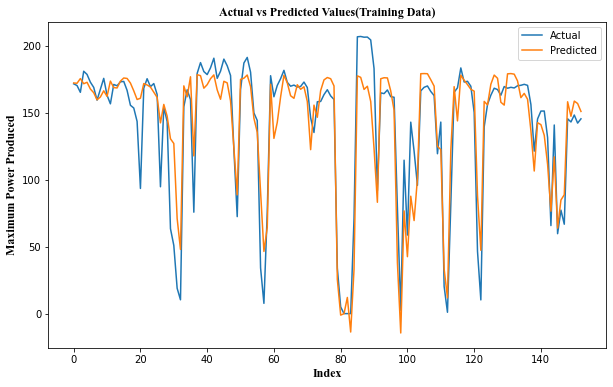

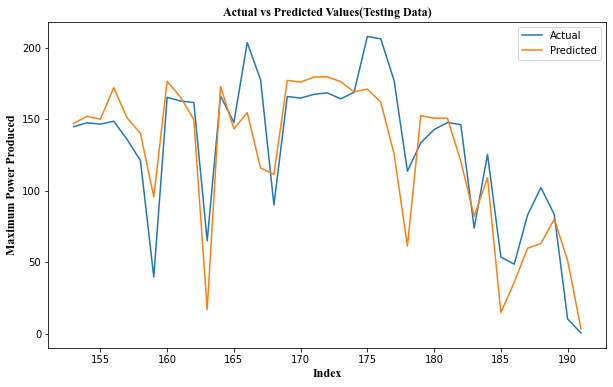

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()


In [9]:
results = results.append({"Model_name":"Radial Basis Function Neural Network","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,27.642515


# LSTM

In [22]:
train_size = int(len(df) * 0.8)
train_data = df[:int(0.8 * len(df))].copy()
test_data = df[int(0.8 * len(df)):].copy()

scaler = MinMaxScaler()
train_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']] = scaler.fit_transform(train_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']])
train_data = train_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']].copy()
test_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']] = scaler.transform(test_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']])
test_data = test_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']].copy()

time_steps = 5

def create_sequences(dated_data, time_steps):
    X = []
    y = []
    for i in range(len(dated_data) - time_steps):        
        X.append(dated_data.iloc[i:i + time_steps, :2].values)
        y.append(dated_data.iloc[i + time_steps, 2])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

X_train = X_train.reshape(-1, time_steps, 2)
X_test = X_test.reshape(-1, time_steps, 2)



model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(lr=0.01))
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
5/5 [==============================] - 10s 472ms/step - loss: 0.2306 - val_loss: 0.1087
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 0.1309 - val_loss: 0.0596
Epoch 3/50
5/5 [==============================] - 0s 18ms/step - loss: 0.0748 - val_loss: 0.0879
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 0.0836 - val_loss: 0.0576
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 0.0709 - val_loss: 0.0603
Epoch 6/50
5/5 [==============================] - 0s 25ms/step - loss: 0.0680 - val_loss: 0.0594
Epoch 7/50
5/5 [==============================] - 0s 30ms/step - loss: 0.0648 - val_loss: 0.0627
Epoch 8/50
5/5 [==============================] - 0s 30ms/step - loss: 0.0663 - val_loss: 0.0576
Epoch 9/50
5/5 [==============================] - 0s 30ms/step - loss: 0.0696 - val_loss: 0.0576
Epoch 10/50
5/5 [==============================] - 0s 30ms/step - loss: 0.0679 - val_loss: 0.0602
Epoch 11/50
5/5 [==========

In [23]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

y_pred = scaler.inverse_transform(np.hstack((X_test[:, -1, :2], y_pred.reshape(-1, 1))))
y_pred = y_pred[:, -1]

y_test_is = scaler.inverse_transform(np.hstack((X_test[:, -1, :2], y_test.reshape(-1, 1))))
y_test_is = y_test_is[:, -1]

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_is, y_pred)

print('RMSE on test data (original):', np.sqrt(mse))

y_train_pred = scaler.inverse_transform(np.hstack((X_train[:, -1, :2], y_train_pred.reshape(-1, 1))))
y_train_pred = y_train_pred[:, -1]

y_train_is = scaler.inverse_transform(np.hstack((X_train[:, -1, :2], y_train.reshape(-1, 1))))
y_train_is = y_train_is[:, -1]

mse_t = mean_squared_error(y_train_is, y_train_pred)

print('RMSE on train data (original):', np.sqrt(mse_t))


5/5 [==============================] - 0s 6ms/step
RMSE on test data (original): 47.18099766548433
RMSE on train data (original): 39.417252833126376


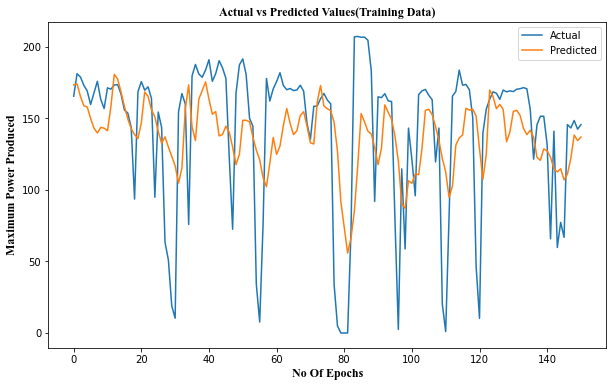

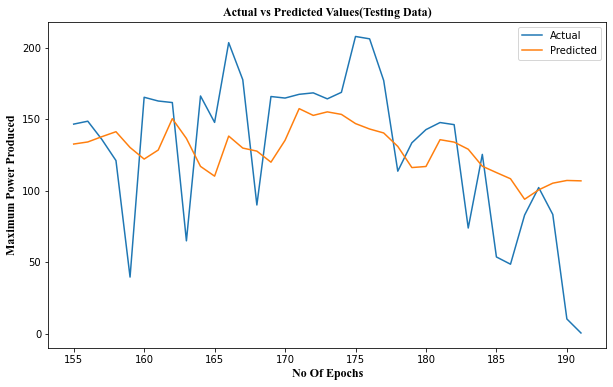

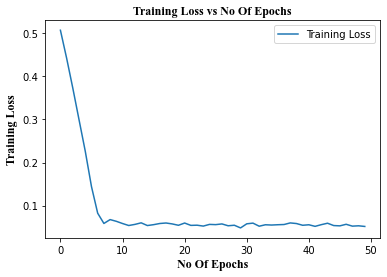

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size-time_steps], y_train_is, label='Actual')
plt.plot(df.index[:train_size-time_steps], y_train_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size+time_steps:], y_test_is, label='Actual')
plt.plot(df.index[train_size+time_steps:], y_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.title("Training Loss vs No Of Epochs" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Training Loss", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()
plt.show(model)

In [13]:
results = results.append({"Model_name":"LSTM Neural Network","RMSE": np.sqrt(mse)}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,27.642515
1,LSTM Neural Network,44.923845


# Modular Neural Network

In [88]:


X = df.copy()[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df.copy()['Power(Watts)'].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

input_shape = (2,)

inputs = layers.Input(shape=input_shape, name="inputs")

x = layers.Dense(12, activation="relu", name="dense1")(inputs)
x = layers.Dense(32, activation="relu", name="dense2")(x)
x = layers.Dense(64, activation="relu", name="dense3")(x)


outputs = layers.Dense(1, activation="linear", name="outputs")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="modular_nn")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse"
)

history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_test, y_test))






Epoch 1/50
10/10 [==============================] - 1s 33ms/step - loss: 0.1882 - val_loss: 0.0416
Epoch 2/50
10/10 [==============================] - 0s 10ms/step - loss: 0.0372 - val_loss: 0.0356
Epoch 3/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0312 - val_loss: 0.0308
Epoch 4/50
10/10 [==============================] - 0s 8ms/step - loss: 0.0270 - val_loss: 0.0271
Epoch 5/50
10/10 [==============================] - 0s 9ms/step - loss: 0.0221 - val_loss: 0.0231
Epoch 6/50
10/10 [==============================] - 0s 10ms/step - loss: 0.0192 - val_loss: 0.0194
Epoch 7/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0169 - val_loss: 0.0237
Epoch 8/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0183 - val_loss: 0.0217
Epoch 9/50
10/10 [==============================] - 0s 17ms/step - loss: 0.0163 - val_loss: 0.0242
Epoch 10/50
10/10 [==============================] - 0s 17ms/step - loss: 0.0166 - val_loss: 0.0203
Epoch 11/50


In [89]:
y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')
print(f'\n')
model.summary()

5/5 [==============================] - 0s 2ms/step
Test Root Mean Squared Error: 26.0722707489
Train Root Mean Squared Error: 20.6869838714


Model: "modular_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 2)]               0         
                                                                 
 dense1 (Dense)              (None, 12)                36        
                                                                 
 dense2 (Dense)              (None, 32)                416       
                                                                 
 dense3 (Dense)              (None, 64)                2112      
                                                                 
 outputs (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,629
Trainable params: 2,629
No

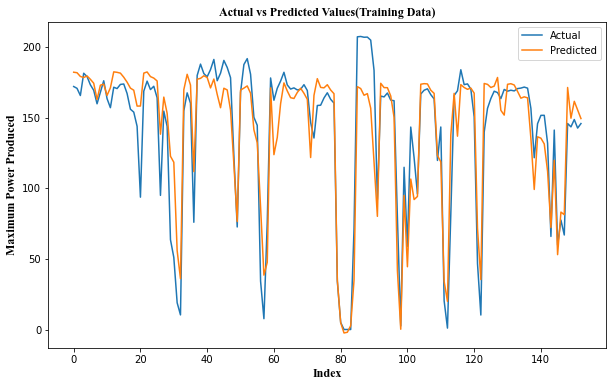

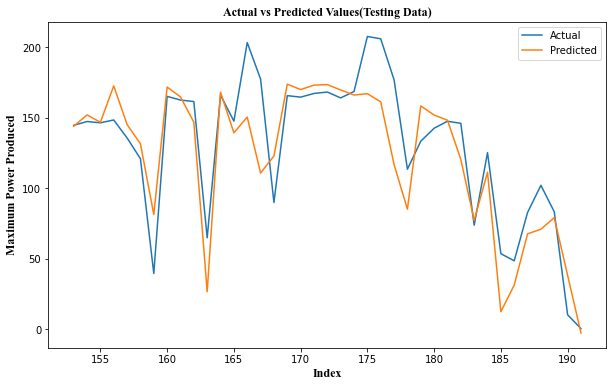

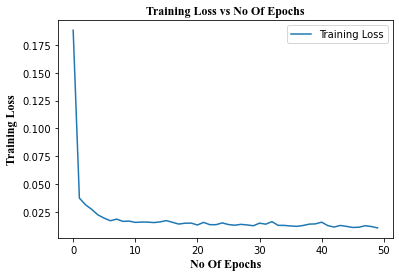

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.title("Training Loss vs No Of Epochs" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Training Loss", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()
plt.show(model)

In [91]:
results = results.append({"Model_name":"Modular Neural Network","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,27.642515
1,LSTM Neural Network,44.923845
2,Modular Neural Network,30.152841
3,Linear Regression(G and T),31.218616
4,Support Vector Machines,26.543223
5,Decision Tree Regressor,52.566944
6,Random forest Regressor,52.627265
7,Orthogonal linear regression,31.191540
8,Quantile linear regression,34.107314
9,Linear regression(G^2 and T),31.807922


# Linear Regression (G and T) 

In [18]:

X = df[[ 'Irradiance(W/m2)', 'Temperature(Â°C)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0225876515
Regression equation: Y = P = 1.19T + -0.01IR - 0.21


In [19]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 31.2186155253
Train Root Mean Squared Error: 27.6844979770


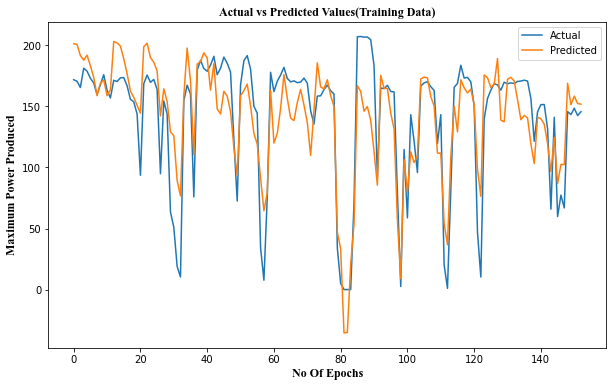

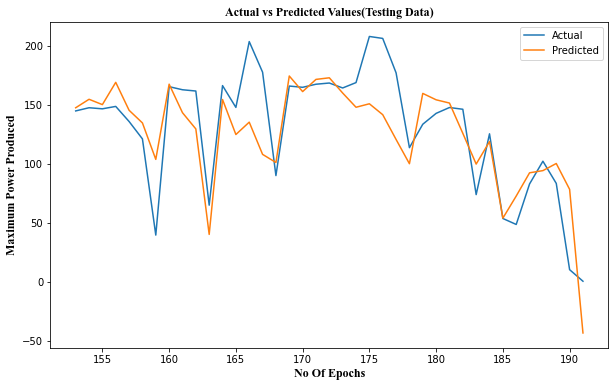

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [21]:
results = results.append({"Model_name":"Linear Regression(G and T)","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,27.642515
1,LSTM Neural Network,44.923845
2,Modular Neural Network,30.152841
3,Linear Regression(G and T),31.218616


# Support Vector Machines

In [22]:
X = df[['Irradiance(W/m2)', 'Irradiance(W/m2)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



model = SVR(kernel='rbf')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse_5 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_5:.10f}')

Mean Squared Error: 0.0163286809


In [23]:
y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 26.5432226821
Train Root Mean Squared Error: 22.5584594552


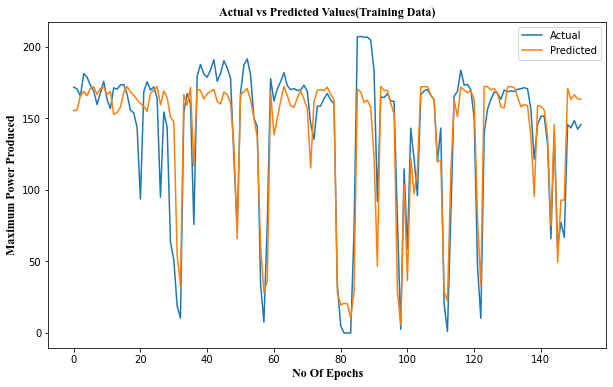

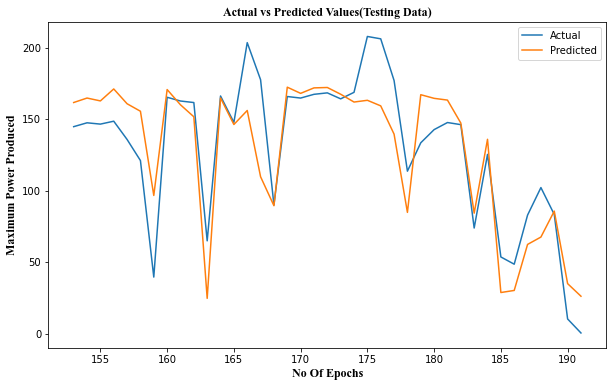

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [25]:
results = results.append({"Model_name":"Support Vector Machines","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,27.642515
1,LSTM Neural Network,44.923845
2,Modular Neural Network,30.152841
3,Linear Regression(G and T),31.218616
4,Support Vector Machines,26.543223


# Decision Tree Regressor

In [80]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

model = DecisionTreeRegressor( max_depth= 50, min_samples_leaf=10)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 28.3790973445
Train Root Mean Squared Error: 17.8732230334


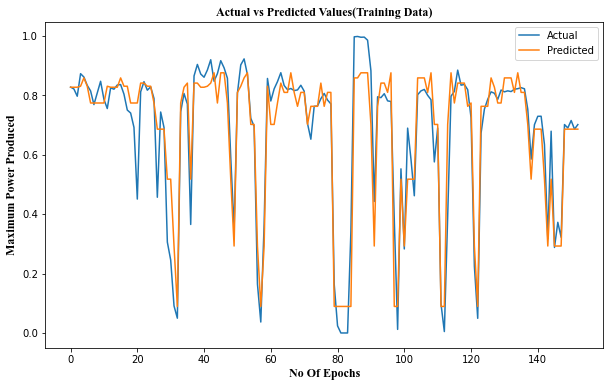

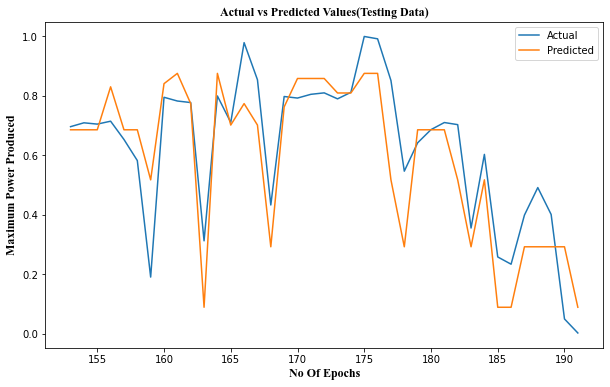

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y_train, label='Actual')
plt.plot(df.index[:train_size], y_train_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], y_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [28]:
results = results.append({"Model_name":"Decision Tree Regressor","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,27.642515
1,LSTM Neural Network,44.923845
2,Modular Neural Network,30.152841
3,Linear Regression(G and T),31.218616
4,Support Vector Machines,26.543223
5,Decision Tree Regressor,52.566944


# Random forest regressor

In [67]:



X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

n_estimators = 200  # number of decision trees
model = RandomForestRegressor(n_estimators=n_estimators, max_depth= 50, min_samples_leaf=7)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 27.0277441104
Train Root Mean Squared Error: 17.6171383467


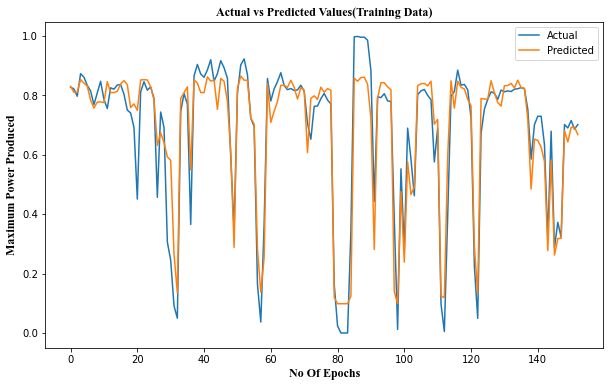

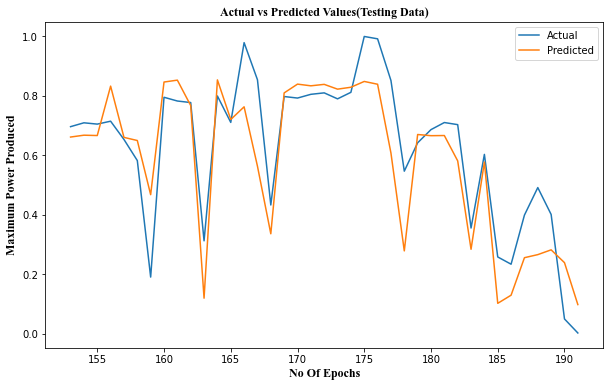

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y_train, label='Actual')
plt.plot(df.index[:train_size], y_train_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], y_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [31]:
results = results.append({"Model_name":"Random forest Regressor","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,27.642515
1,LSTM Neural Network,44.923845
2,Modular Neural Network,30.152841
3,Linear Regression(G and T),31.218616
4,Support Vector Machines,26.543223
5,Decision Tree Regressor,52.566944
6,Random forest Regressor,52.627265


# Orthogonal linear regression

In [32]:
X = df.copy()[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df.copy()['Power(Watts)'].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

model = OrthogonalMatchingPursuit()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [33]:
y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')

results = results.append({"Model_name":"Orthogonal linear regression","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 31.1915398116


,Model_name,RMSE
0,Radial Basis Function Neural Network,27.642515
1,LSTM Neural Network,44.923845
2,Modular Neural Network,30.152841
3,Linear Regression(G and T),31.218616
4,Support Vector Machines,26.543223
5,Decision Tree Regressor,52.566944
6,Random forest Regressor,52.627265
7,Orthogonal linear regression,31.191540


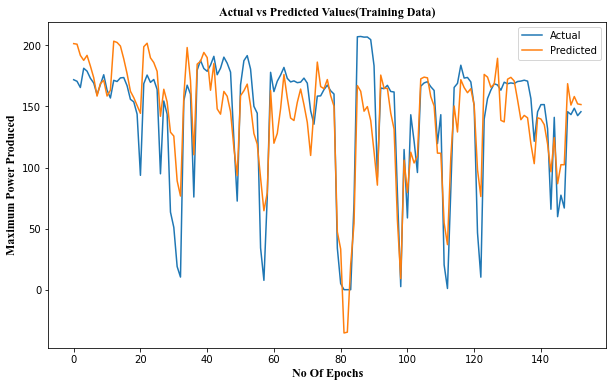

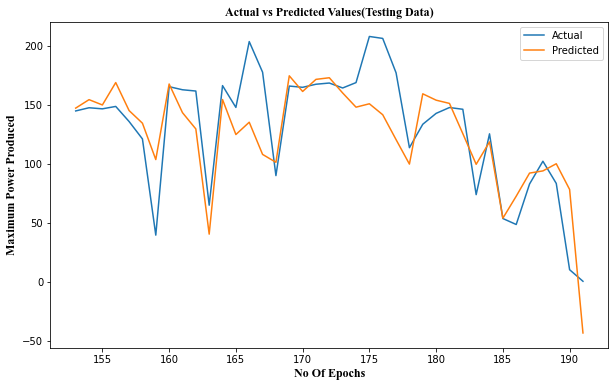

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Quantile Linear regression

In [35]:
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

X = df.copy()[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df.copy()['Power(Watts)'].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]


quantile_model = sm.QuantReg(y_train, X_train)
quantile_result = quantile_model.fit(q=0.2)  # Change the quantile value as needed

predicted_power = quantile_result.predict(X)



In [36]:
y_pred = quantile_result.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = quantile_result.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Quantile linear regression","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 34.1073137879
Train Root Mean Squared Error: 31.9648354055


,Model_name,RMSE
0,Radial Basis Function Neural Network,27.642515
1,LSTM Neural Network,44.923845
2,Modular Neural Network,30.152841
3,Linear Regression(G and T),31.218616
4,Support Vector Machines,26.543223
5,Decision Tree Regressor,52.566944
6,Random forest Regressor,52.627265
7,Orthogonal linear regression,31.191540
8,Quantile linear regression,34.107314


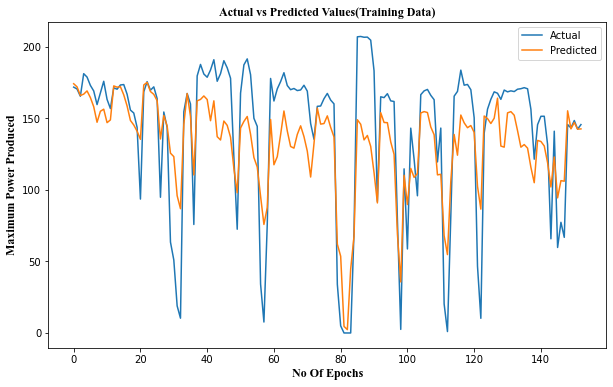

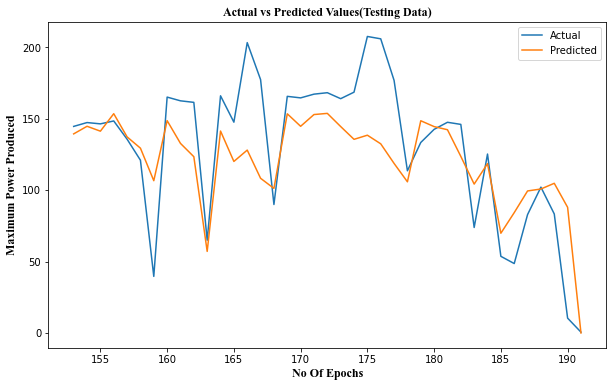

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Linear Regression(G^2 and T)

In [38]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']]
X["Irradiance(W/m2)"] = X["Irradiance(W/m2)"]**2
X = X.values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR^2 - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0234484638
Regression equation: Y = P = -0.04T + 0.99IR^2 - 0.07


In [39]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Linear regression(G^2 and T)","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 31.8079219502
Train Root Mean Squared Error: 29.7211255929


,Model_name,RMSE
0,Radial Basis Function Neural Network,27.642515
1,LSTM Neural Network,44.923845
2,Modular Neural Network,30.152841
3,Linear Regression(G and T),31.218616
4,Support Vector Machines,26.543223
5,Decision Tree Regressor,52.566944
6,Random forest Regressor,52.627265
7,Orthogonal linear regression,31.191540
8,Quantile linear regression,34.107314
9,Linear regression(G^2 and T),31.807922


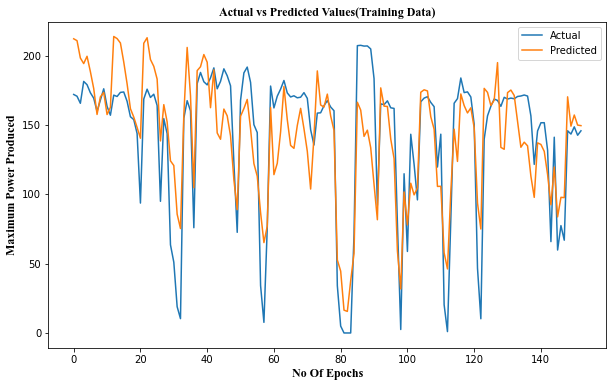

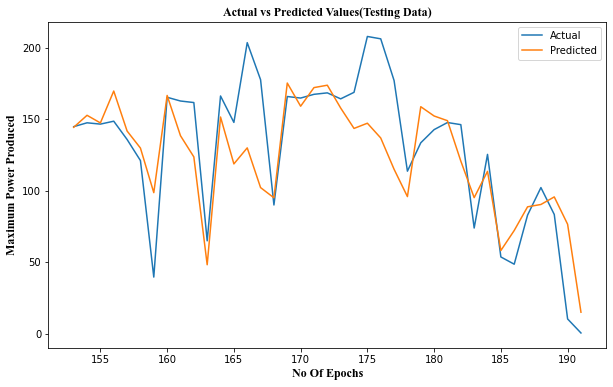

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Linear Regression(G^2 and T^2)

In [41]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']]
X["Temperature(Â°C)"] = X["Temperature(Â°C)"]**2
X["Irradiance(W/m2)"] = X["Irradiance(W/m2)"]**2
X = X.values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR^2 - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0235994656
Regression equation: Y = P = -0.15T + 1.06IR^2 - 0.06


In [42]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Linear regression(G^2 and T^2)","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 31.9101748215
Train Root Mean Squared Error: 29.4661419618


,Model_name,RMSE
0,Radial Basis Function Neural Network,27.642515
1,LSTM Neural Network,44.923845
2,Modular Neural Network,30.152841
3,Linear Regression(G and T),31.218616
4,Support Vector Machines,26.543223
5,Decision Tree Regressor,52.566944
6,Random forest Regressor,52.627265
7,Orthogonal linear regression,31.191540
8,Quantile linear regression,34.107314
9,Linear regression(G^2 and T),31.807922


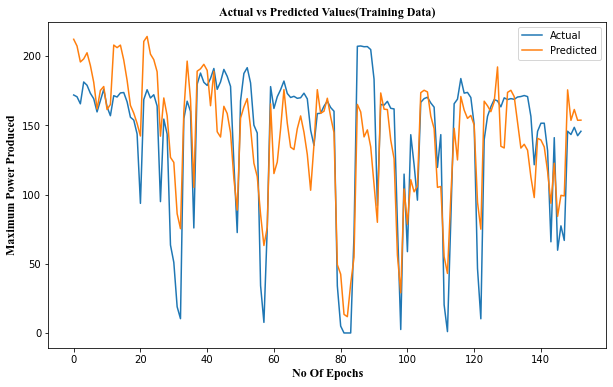

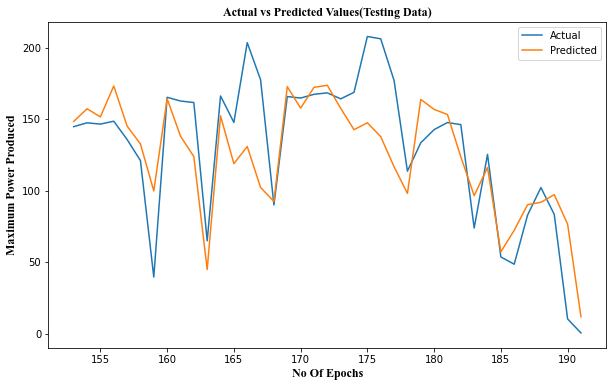

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Linear Regression(G and T^2)

In [44]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']]
X["Temperature(Â°C)"] = X["Temperature(Â°C)"]**2
X = X.values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR^2 - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0229936584
Regression equation: Y = P = -0.08T + 1.24IR^2 - 0.22


In [45]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Linear regression(G and T^2)", "RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 31.4979389709
Train Root Mean Squared Error: 27.5921287861


,Model_name,RMSE
0,Radial Basis Function Neural Network,27.642515
1,LSTM Neural Network,44.923845
2,Modular Neural Network,30.152841
3,Linear Regression(G and T),31.218616
4,Support Vector Machines,26.543223
5,Decision Tree Regressor,52.566944
6,Random forest Regressor,52.627265
7,Orthogonal linear regression,31.191540
8,Quantile linear regression,34.107314
9,Linear regression(G^2 and T),31.807922


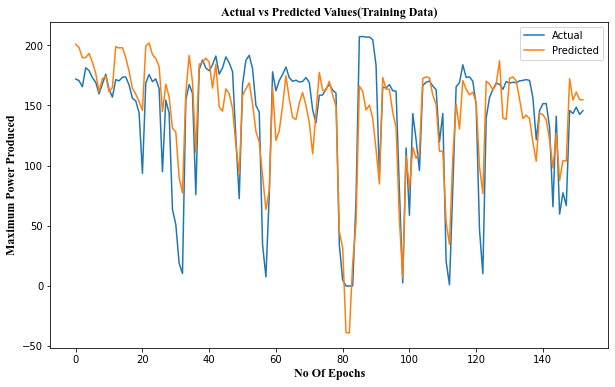

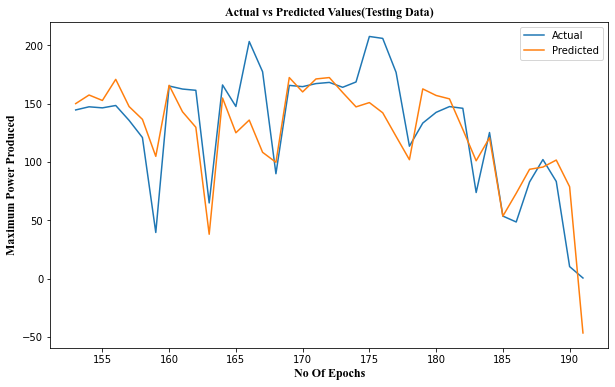

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Ridge Regression

In [47]:

X = df[[ 'Irradiance(W/m2)', 'Temperature(Â°C)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = Ridge(alpha=0.3)

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Ridge regression","RMSE": rmse_1}, ignore_index = True)
results

Mean Squared Error: 0.0219038791
Test Root Mean Squared Error: 30.7424600008
Train Root Mean Squared Error: 27.8885308772


,Model_name,RMSE
0,Radial Basis Function Neural Network,27.642515
1,LSTM Neural Network,44.923845
2,Modular Neural Network,30.152841
3,Linear Regression(G and T),31.218616
4,Support Vector Machines,26.543223
5,Decision Tree Regressor,52.566944
6,Random forest Regressor,52.627265
7,Orthogonal linear regression,31.191540
8,Quantile linear regression,34.107314
9,Linear regression(G^2 and T),31.807922


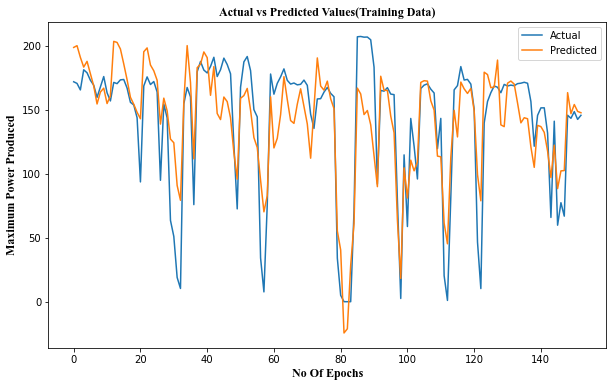

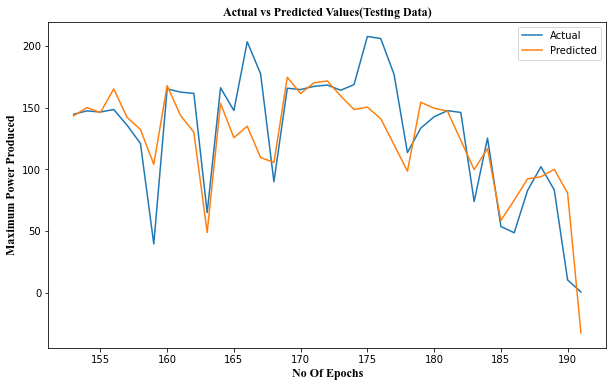

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Kernel Ridge Regression

In [49]:
from sklearn.kernel_ridge import KernelRidge

X = df[[ 'Irradiance(W/m2)', 'Temperature(Â°C)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = KernelRidge(kernel='rbf', alpha=0.1)

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)


y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Kernal Ridge regression","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 29.3573894846
Train Root Mean Squared Error: 24.3197942936


,Model_name,RMSE
0,Radial Basis Function Neural Network,27.642515
1,LSTM Neural Network,44.923845
2,Modular Neural Network,30.152841
3,Linear Regression(G and T),31.218616
4,Support Vector Machines,26.543223
5,Decision Tree Regressor,52.566944
6,Random forest Regressor,52.627265
7,Orthogonal linear regression,31.191540
8,Quantile linear regression,34.107314
9,Linear regression(G^2 and T),31.807922


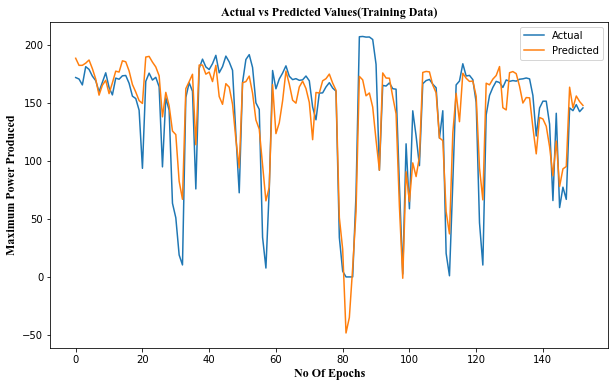

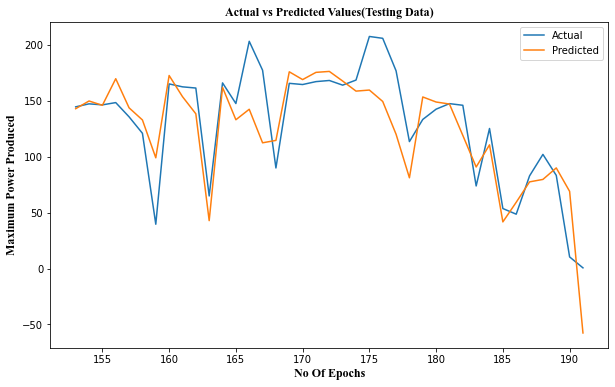

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [51]:
results.sort_values("RMSE").reset_index().drop("index", axis = 1)

,Model_name,RMSE
0,Support Vector Machines,26.543223
1,Radial Basis Function Neural Network,27.642515
2,Kernal Ridge regression,29.357389
3,Modular Neural Network,30.152841
4,Ridge regression,30.742460
5,Orthogonal linear regression,31.191540
6,Linear Regression(G and T),31.218616
7,Linear regression(G and T^2),31.497939
8,Linear regression(G^2 and T),31.807922
9,Linear regression(G^2 and T^2),31.910175


In [52]:
results.sort_values("RMSE").reset_index().drop("index", axis = 1)

,Model_name,RMSE
0,Support Vector Machines,26.543223
1,Radial Basis Function Neural Network,27.642515
2,Kernal Ridge regression,29.357389
3,Modular Neural Network,30.152841
4,Ridge regression,30.742460
5,Orthogonal linear regression,31.191540
6,Linear Regression(G and T),31.218616
7,Linear regression(G and T^2),31.497939
8,Linear regression(G^2 and T),31.807922
9,Linear regression(G^2 and T^2),31.910175
